# Lab 4: Transform coding

This lab aims to get familiar with transform coding methods based on the DFT and DCT transforms.

## Reference concepts

### Transform coding
It refers to the techniques used in signal compression that convert a signal from its original domain (such as the time domain or spatial domain) into a different domain, typically the frequency domain, where the signal can be represented more efficiently. The goal of transform coding is to reduce the amount of data required to represent the signal by taking advantage of redundancies or perceptual irrelevancies.

### Discrete Fourier Transform (DFT)
The DFT is the basic frequency-domain transformation, conceptually easy to understand, and suitable for most kind of spectral analysis and spectral transformations. However, the STFT, built on top of the DFT, requires overlapping between windows, but it doubles the information that need to be stored: not very good for compression.

### Discrete Cosine Transform (DCT)
The DCT is a transform similar to the DFT but using only real numbers. It expresses a finite sequence of data points in terms of a sum of cosine functions oscillating at different frequencies. The DCT is widely used in applications such as audio, image, and video compression due to its ability to concentrate energy in a small number of coefficients.

### Modified Discrete Cosine Transform (MDCT)
The MDCT is an extension of the DCT, designed specifically for audio compression algorithms such as MP3 or AAC. The MDCT helps to reduce blocking artifacts and efficiently compress overlapping blocks of data, which is particularly important for perceptual audio coding.


In [1]:
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, dct, idct
from scipy.io.wavfile import read
import IPython.display as ipd

In [2]:
# functions used in the whole lab
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  # read sound file
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # plot the waveform of the sound
  plt.figure(0, figsize=(10, 2))
  time_indexes = np.arange(0, sound_array.size/sampling_rate, 1.0/sampling_rate)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  plt.show()
  # play the sound
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

## Part 1 - DFT, DCT

Compare the DFT with the DCT. Answer the questions given while modifying the code as needed to support the answers.

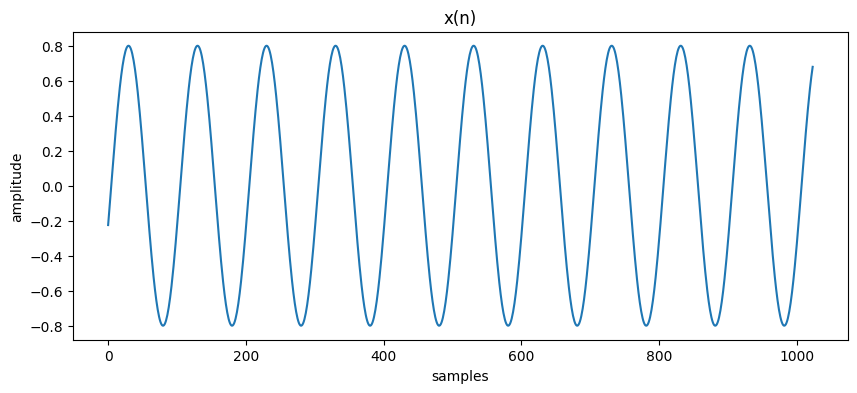

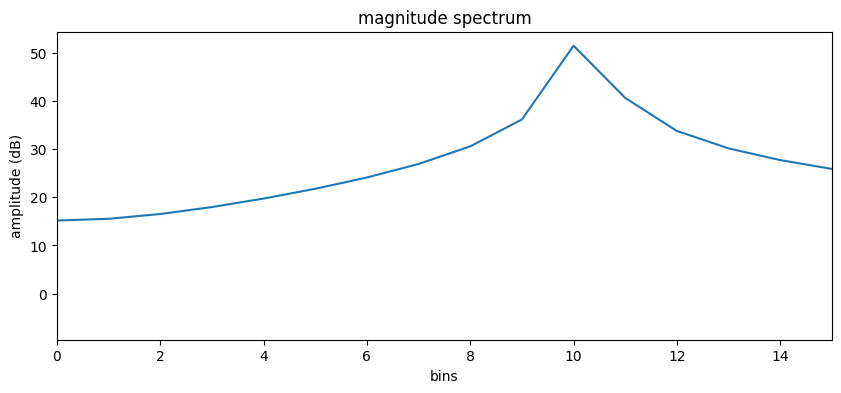

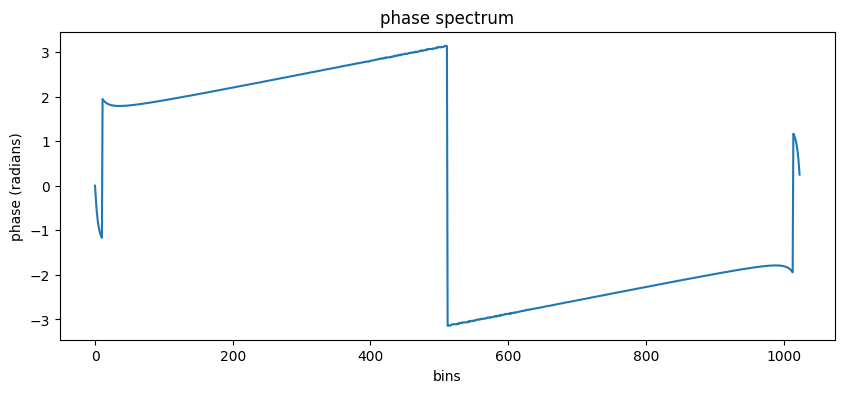

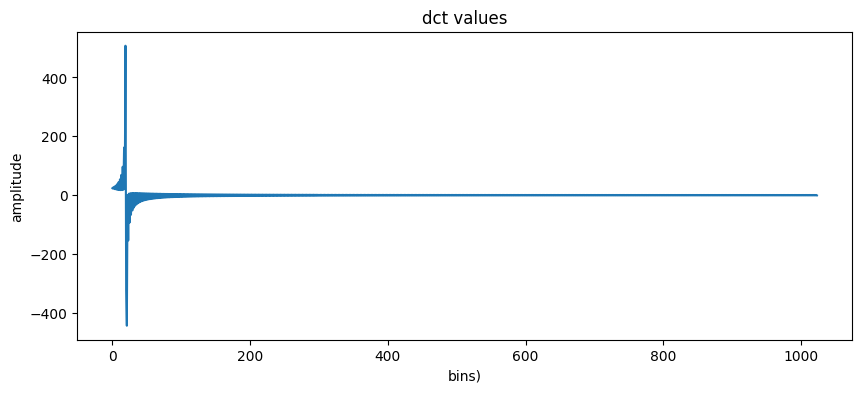

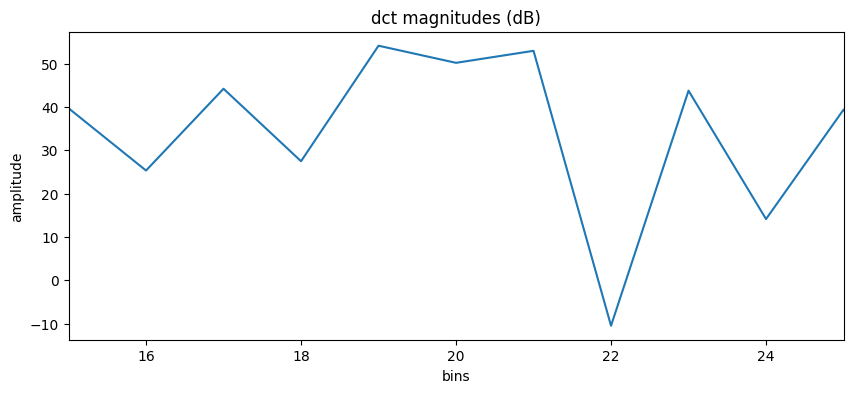

In [22]:
# perform dft and dct of a sinewave

x, fs = read_sound('../sounds/sinewave.wav')
N = 1024
xf = x[2000:2000+N]

plt.figure(1, figsize=(10, 4))
plt.plot(xf)
plt.xlabel('samples')
plt.ylabel('amplitude')
plt.title('x(n)')
plt.show()

X_dft = fft(xf)
plt.figure(1, figsize=(10, 4))
plt.plot(20*np.log10(np.abs(X_dft)))
plt.xlabel('bins')
plt.ylabel('amplitude (dB)')
plt.title('magnitude spectrum')
plt.xlim(0,15)
plt.show()

X_dft = fft(xf)
plt.figure(1, figsize=(10, 4))
plt.plot(np.angle(X_dft))
plt.xlabel('bins')
plt.ylabel('phase (radians)')
plt.title('phase spectrum')
plt.show()

X_dct = dct(xf, type=4)
plt.figure(0, figsize=(10, 4))
plt.plot(X_dct)
plt.xlabel('bins)')
plt.ylabel('amplitude')
plt.title('dct values')
plt.show()

plt.figure(0, figsize=(10, 4))
plt.plot(20*np.log10(np.abs(X_dct)))
plt.xlabel('bins')
plt.ylabel('amplitude')
plt.title('dct magnitudes (dB)')
plt.xlim(15,25)
plt.show()

**Questions:**

**1. Compute the DFT and the DCT of a sinewave and describe the similarities and differences of the outputs obtained. Find the location of the peak in the magnitudes of both spectra. What is the difference.**
The DFT output shows a symmetric magnitude spectrum due to the inclusion of both positive and negative frequencies (complex numbers). Therefore, only the first half of the spectrum is relevant. The fundamental frequency of the sinewave is represented by the peak in the first half. In our case, zooming in with plt.xlim(0, 50) shows the peak at the 10th bin.

In contrast, the DCT handles only real numbers, so we'll have the double of information bins. In this case, the DCT magnitude spectrum lacks the symmetry seen in the DFT and shows two prominent peaks. Using *plt.xlim(15,25)* we can see that the two peaks are at bins 19 and 21, which are around 20, the double of the numnber of the bin in DFT. 

**2. Compute the DFT and DCT of a complex sound (one of the sounds in the sounds directory), and compare and describe their spectrum.**
For the complex sound of a tuba, we get similar plots, but the curves become more "shaky". This is because of the extra frequency components of the tuba. 

Same as before, the spectrum of the DFT shows a full magnitude response that is symmetrical, capturing both positive and negative frequencies. The peaks represent the dominant frequencies of the tuba note, with the first peak indicating the fundamental frequency and additional peaks showing its harmonics. Using *plt.xlim(0, 15)* we can see that the peak is at bin 8 (fundamental frequency).

The DCT, again, concentrates most of the energy in the lower frequency bins, with a sharp decay as frequency increases. Using *plt.xlim(15,25)* we can see that the peak is at bin 16.
____

## Part 2 - STFT, MCDT

Compute and compare a coding/decoding system using both the STFT and the MDCT. Answer the questions given while modifying the code as needed to support the answers.

In [4]:
# functions needed to compute mdct

N = 1024

#The D(z) matrix:
def Dmatrix(samples):
    #implementation of the delay matrix D(z)
    N = len(samples)
    out=np.zeros(N)
    out[0:int(N/2)]=Dmatrix.z
    Dmatrix.z=samples[0:int(N/2)]
    out[int(N/2):N]=samples[int(N/2):N]
    return out

Dmatrix.z=np.zeros(N//2)

#The inverse D(z) matrix:
def Dmatrixinv(samples):
    #implementation of the delay matrix D(z)
    N = len(samples)
    out=np.zeros(N)
    out[int(N/2):N]=Dmatrixinv.z
    Dmatrixinv.z=samples[int(N/2):N]
    out[0:int(N/2)]=samples[0:int(N/2)]
    return out

Dmatrixinv.z=np.zeros(int(N/2))

#The F Matrix:
fcoeff=np.sin(np.pi/(2*N)*(np.arange(0,2*N)+0.5))
Fmatrix=np.zeros((N,N))
Fmatrix[0:int(N/2),0:int(N/2)]=np.fliplr(np.diag(fcoeff[0:int(N/2)]))
Fmatrix[int(N/2):N,0:int(N/2)]=np.diag(fcoeff[int(N/2):N])
Fmatrix[0:int(N/2),int(N/2):N]=np.diag(fcoeff[N:int(N+N/2)])
Fmatrix[int(N/2):N,int(N/2):N]=-np.fliplr(np.diag(fcoeff[int(N+N/2):(2*N)]))

#The inverse F matrix:
Finv=np.linalg.inv(Fmatrix)

#The complete MDCT, Analysis:
def MDCT(samples):
    y=np.dot(samples,Fmatrix)
    y=Dmatrix(y)
    y=dct(y,type=4)
    return y

#The inverse MDCT, synthesis:
def MDCTinv(y):
    #inverse DCT4 is identical to DCT4:
    x=idct(y,type=4)/(2*len(y))
    #inverse D(z) matrix
    x=Dmatrixinv(x)
    #inverse F matrix
    x=np.dot(x,Finv)
    return x

def display_spectrogram_mcdt(x, N, fs=44100):
  i = 0
  Xf = []
  while i < x.size-N:
    X = MDCT(x[i:i+N])
    Xf.append(np.array(X))
    i += N

  Xf = np.array(Xf)
  plt.figure(figsize=(10, 5))
  plt.pcolormesh(np.transpose(20*np.log10(np.abs(Xf))), shading='auto', cmap='inferno')
  plt.colorbar(format='%+2.0f dB')
  plt.xlabel('frames')
  plt.ylabel('bins')
  plt.show()

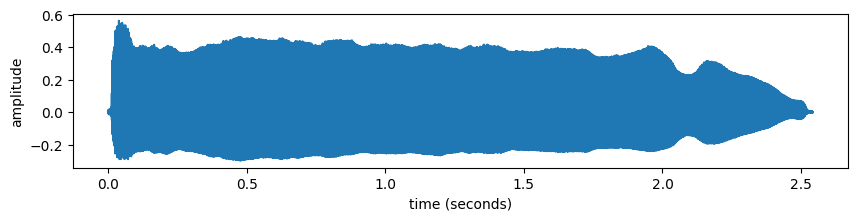

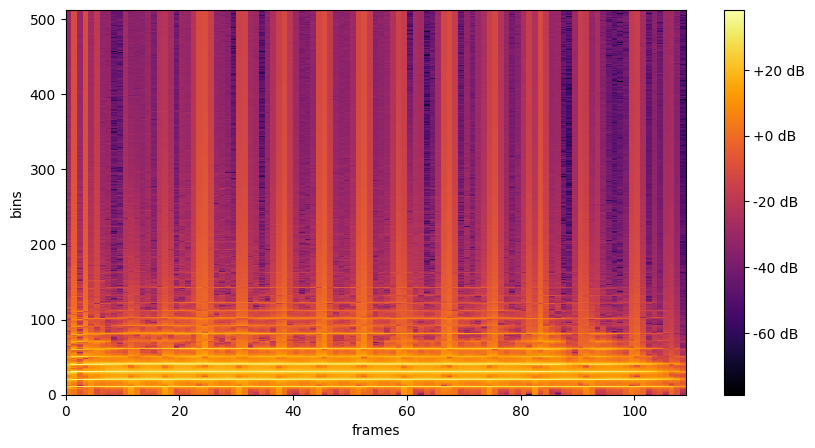

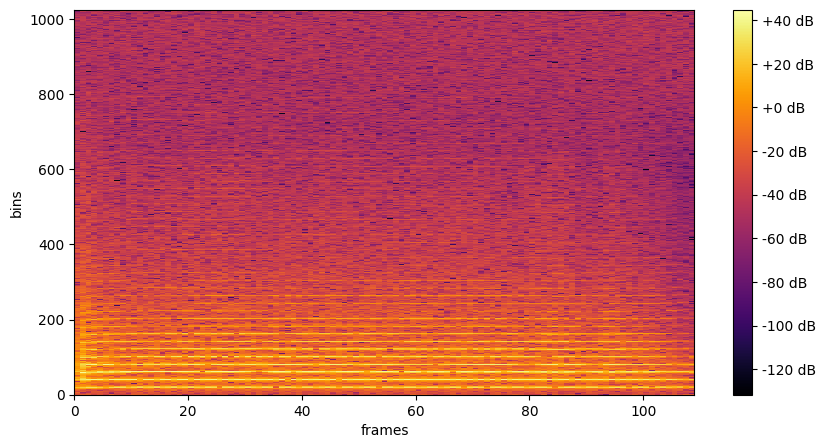

In [5]:
# compute the spectrogram of a sound using both the STFT and the MDCT

def display_spectrogram_stft(sound_array, fft_size=512, sampling_rate=44100):
  # initialize the output spectrogram
  magnitude_spectrogram = []
  sample_index = 0
  # iterate over the input sound computing a sequence of spectra
  while sample_index < sound_array.size-fft_size:
    spectrum = fft(sound_array[sample_index:sample_index+fft_size])
    magnitude_spectrum = 20*np.log10(abs(spectrum[:spectrum.size//2]))
    magnitude_spectrogram.append(magnitude_spectrum)
    sample_index += fft_size

  # plot the magnitude sspectrogram
  plt.figure(figsize=(10, 5))
  plt.pcolormesh(np.transpose(magnitude_spectrogram), shading='auto', cmap='inferno')
  plt.colorbar(format='%+2.0f dB')
  plt.xlabel('frames')
  plt.ylabel('bins')
  plt.show()

x, fs = read_sound('../sounds/487465-trumpet.wav')
display_sound(x, fs)

display_spectrogram_stft(x, N, 1)

display_spectrogram_mcdt(x, N, fs)

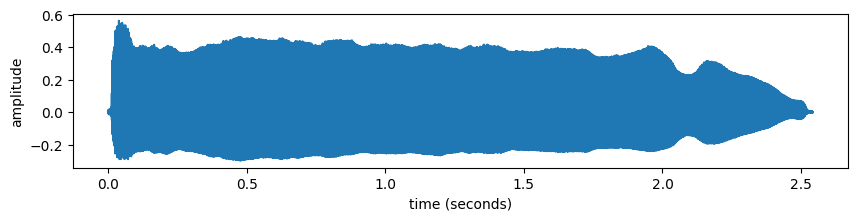

C:\Users\alexp\AppData\Local\Temp\ipykernel_18816\3903272623.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  y[i*len(Xf[0,:]):i*len(Xf[0,:])+len(yt)] = yt


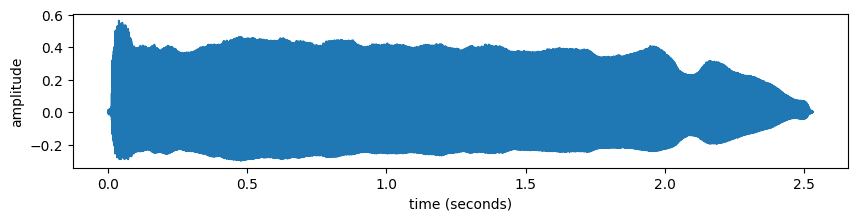

In [23]:
# perform STFT and inverse STFT

def compute_stft(x, N, fs=44100):
  i = 0
  Xf = []
  while i < x.size-N:
    X = fft(x[i:i+N])
    Xf.append(np.array(X))
    i += N
  return(np.array(Xf))

def compute_inverse_stft(Xf, fs=44100):
  i = 0
  y = np.zeros(len(Xf[0,:])*len(Xf[:,0]))
  for i in range(len(Xf[:,0])):
    yt = ifft(Xf[i,:])
    y[i*len(Xf[0,:]):i*len(Xf[0,:])+len(yt)] = yt
  return(y)

x, fs = read_sound('../sounds/487465-trumpet.wav')
display_sound(x, fs)

Xf = compute_stft(x, N, fs)
y = compute_inverse_stft(Xf, fs)
display_sound(y, fs)

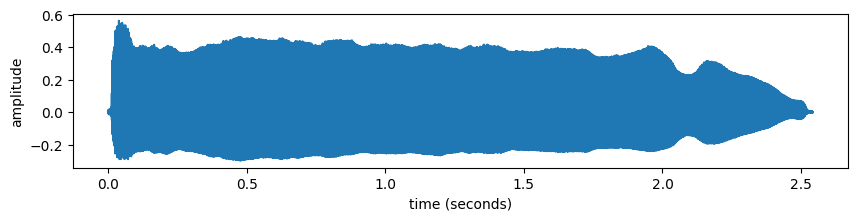

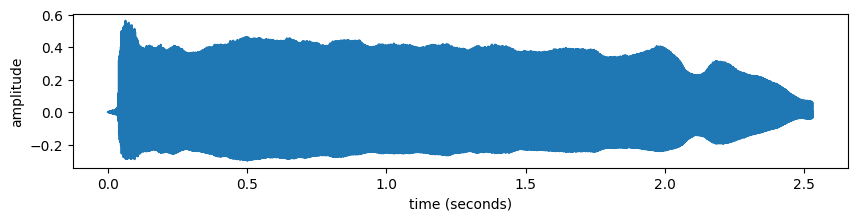

In [6]:
# perform MCDT and inverse MCDT

def compute_mcdt(x, N, fs=44100):
  i = 0
  Xf = []
  while i < x.size-N:
    X = MDCT(x[i:i+N])
    Xf.append(np.array(X))
    i += N
  return(np.array(Xf))

def compute_inverse_mcdt(Xf, fs=44100):
  i = 0
  y = np.zeros(len(Xf[0,:])*len(Xf[:,0]))
  for i in range(len(Xf[:,0])):
    yt = MDCTinv(Xf[i,:])
    y[i*len(Xf[0,:]):i*len(Xf[0,:])+len(yt)] = yt
  return(y)

x, fs = read_sound('../sounds/487465-trumpet.wav')
display_sound(x, fs)

Xf = compute_mcdt(x, N, fs)
y = compute_inverse_mcdt(Xf, fs)
display_sound(y, fs)

**Questions:**
**1. Compare the STFT (without window overlapping and using rectangular window) with the MCDT. Perform the analysis/synthesis of 2 distinct sounds using both the STFT and MCDT and compare the results.**

In the spectrogram of the STFT we can observe distinct vertical lines representing some artifacts. This is due to the lack of windowing and overlapping. The lack of windowing causes abrupt transitions at the boundaries of each FFT frame, leading to spectral leakage. Additionally, the absence of overlapping windows results in gaps between frames, reducing the ability to capture continuous changes in the sound's frequency content. 

The MDCT cancels out time-domain aliasing during synthesis, preventing discontinuities and allowing for perfect signal reconstruction without requiring overlapping windows. As shown in the spectrogram, the MDCT produces a smoother representation of the frequency content, especially in the lower frequencies, without any spectral leakage. We can better identify the frequency bands.

**2. Do you obtain an identity system in both? explain.**

When comparing their plotted waveforms:

STFT: Yes, it produces an identity system, meaning the original signal can be perfectly reconstructed after transformation and inverse transformation.

MDCT: No, the MDCT introduces a slight delay due to its processing structure, but this delay does not affect the quality of the reconstruction. The signal is still accurately reconstructed, just with a shifted start time.
___

# Part 3 - Quantizing the MCDT spectrogram

Quantize the MCDT encoded data. Answer the questions given while modifying the code as needed to support the answers.

In [27]:
def quantize_subbands(Xf, target_bits=16):
    """Quantize each subband of the MDCT output to an integer of given number of bits."""

    X_quantized = np.zeros_like(Xf)
    for i in range(len(Xf[0,:])):
      # Scaling the signal to the range of [0, 2^target_bits - 1]
      scaled = (Xf[:,i] - np.min(Xf[:,i])) / (np.max(Xf[:,i]) - np.min(Xf[:,i])) * (2**target_bits - 1)
      # Quantize by rounding
      quantized = np.round(scaled)
      # Re-scaling back to the original amplitude range
      X_quantized[:,i] = (quantized / (2**target_bits - 1)) * (np.max(Xf[:,i]) - np.min(Xf[:,i])) + np.min(Xf[:,i])
    return X_quantized

def quantize_signal(x, target_bits):
  # Scaling the signal to the range of [0, 2^target_bits - 1]
  x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x)) * (2**target_bits - 1)
  # Quantize by rounding
  x_quantized = np.round(x_scaled)
  # Re-scaling back to the original amplitude range
  x_output = (x_quantized / (2**target_bits - 1)) * (np.max(x) - np.min(x)) + np.min(x)
  return x_output

Reconstruction MSE: 0.046597
Bit rate: 10.12390022675737


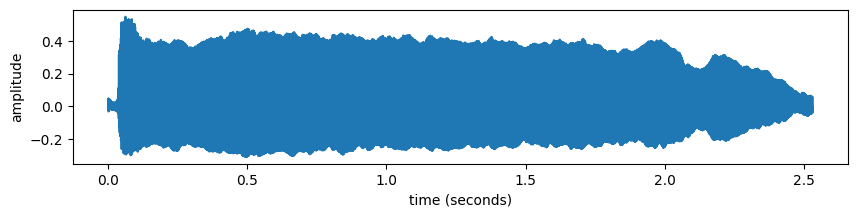

In [31]:
Xf = compute_mcdt(x, N, fs)

# Quantize the MDCT coefficients one band at a time
bitdepth = 4
quantized_Xf = quantize_subbands(Xf, bitdepth)

# Reconstruct the time-domain signal from the MDCT coefficients
x_reconstructed = compute_inverse_mcdt(quantized_Xf, N)
number_samples = len(x_reconstructed)

# Evaluate the Reconstruction Quality
bitrate = bitdepth * number_samples / fs
mse = np.mean((x[:len(x_reconstructed)] - x_reconstructed)**2)
print(f"Reconstruction MSE: {mse:.6f}")
print(f"Bit rate: {bitrate}")

# Plot the reconstructed signal
display_sound(x_reconstructed, fs)

Reconstruction MSE: 0.046437
Bit rate: 17.716825396825396


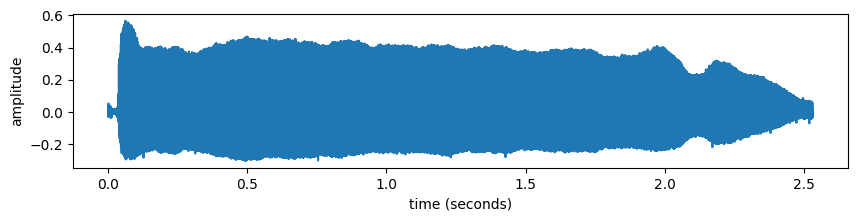

In [36]:
Xf = compute_mcdt(x, N, fs)

# Quantize the MDCT coefficients all together
bitdepth = 7
quantized_Xf = quantize_signal(Xf, bitdepth)

# Reconstruct the time-domain signal from the MDCT coefficients
x_reconstructed = compute_inverse_mcdt(quantized_Xf, N)
number_samples = len(x_reconstructed)

# Evaluate the Reconstruction Quality
bitrate = bitdepth * number_samples / fs
mse = np.mean((x[:len(x_reconstructed)] - x_reconstructed)**2)
print(f"Reconstruction MSE: {mse:.6f}")
print(f"Bit rate: {bitrate}")

# Plot the reconstructed signal
display_sound(x_reconstructed, fs)

Reconstruction MSE: 0.000016
Bit rate: 15.24843537414966


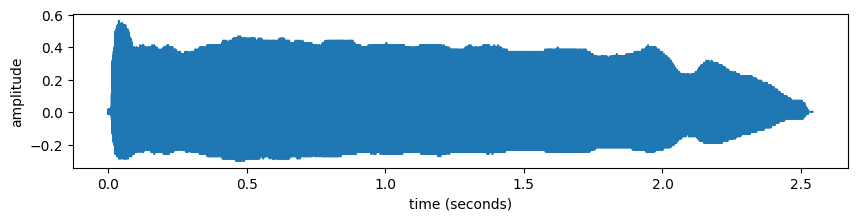

In [38]:
# Quantize the original signal
bitdepth = 6
x_reconstructed = quantize_signal(x, bitdepth)
number_samples = len(x_reconstructed)

# Evaluate the Reconstruction Quality
bitrate = bitdepth * number_samples / fs
mse = np.mean((x[:len(x_reconstructed)] - x_reconstructed)**2)
print(f"Reconstruction MSE: {mse:.6f}")
print(f"Bit rate: {bitrate}")

# Plot the reconstructed signal
display_sound(x_reconstructed, fs)

**Questions:**

**1. Quantize the MDCT output (floting point values) one band at a time, to integer values of different number of bits. Find the lowest number of bits for which you do not hear a difference. Explain the result. (Note: In the code given the quantized data is not stored as integer values, but you can evaluate the results as if it was)**

In the quantization of the MDCT output one band at a time, the lowest number of bits with no audible distortion is 4 bits. However, at the end of the audio, particularly in the last seconds, the trumpet sound becomes slightly distorted, producing a more metallic timbre. This is due to the reduction in precision as the number of bits decreases, which affects the resolution of each band.

**2. Compare the quantization done one band at a time, with the quantization done for the whole MDCT output, with the one done on the original signal. Explain the result.**

Quantizing the MDCT output one band at a time: This approach provides the best results, as different subbands can adapt to lower bit depths without introducing excessive distortion. The audio remains intelligible and relatively clean even with 4 bits, as quantization noise is spread across the subbands, minimizing its effect.

Quantizing the whole MDCT output together: the only bitdepth with which the sound very distorted is with 7 bits. Any different number of bits (larger or smaller) creates significant audible artifacts, likely due to the loss of finer details across all frequency components.

Quantizing the original signal: Quantizing the original time-domain signal required around 7 bits to maintain acceptable quality, but not the best. However, compared to MDCT quantization, distortion was slightly less aggressive. This could be because quantizing in the time domain avoids spreading quantization noise across different frequency bands.

**3. What is the best coding bit-rate obtained compared with the original signal. Explain the result.**

The most optimal coding bit-rate is achieved through the quantization of the MDCT output one band at a time. This method allows for lower bit depths (as low as 4 bits) because each subband represents a specific range of frequencies. By quantizing these subbands independently, the method can better adapt to the characteristics of each frequency range, allowing for more efficient use of bits.

By allocating fewer bits to each subband and maintaining sufficient resolution, we achieve better compression without sacrificing sound quality. In contrast, quantizing the whole MDCT output or the original signal requires more bits (around 7 bits) to avoid severe distortion, which results in a higher bit-rate. Therefore, quantizing each subband individually leads to a more efficient and balanced compression strategy.



---